# Let's reconstruct something more complex: our colleague Alex!
Each Bezier curve from a sketch was previously centered and scaled into a single image. The original bounding box is retained.

In [2]:
import json
import sys
import os
from PIL import Image, ImageDraw

# import the library
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_dir)

from svglib.svg import SVG
from svglib.geom import Point

In [23]:
# load json file with all the patches
sample_dir = os.path.join(root_dir, "samples")
with open(os.path.join(sample_dir, "complex", "metadata.json")) as f:
    patches = json.load(f)
    
width = patches["width"]
height = patches["height"]
patches = patches["parts"]

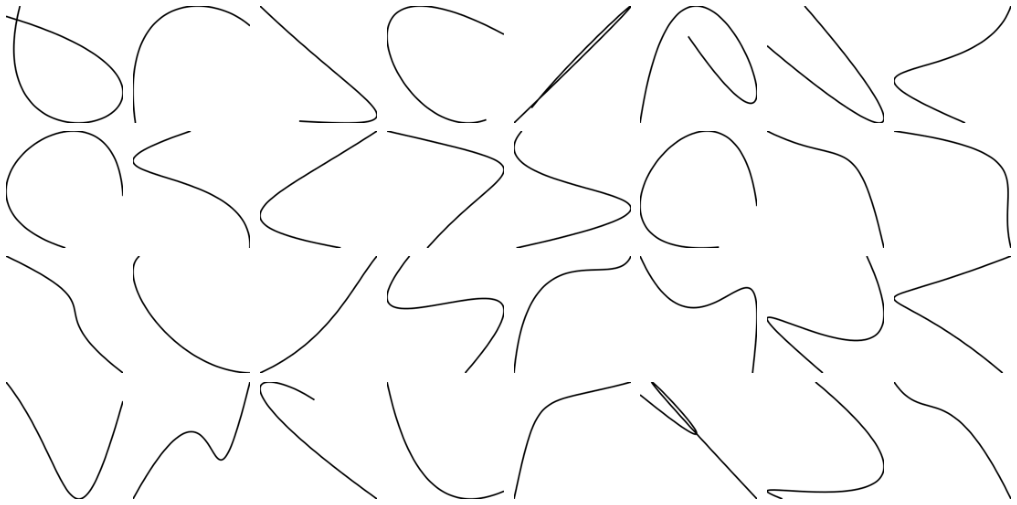

In [36]:
from matplotlib import pyplot as plt

# Display all the svg patches as raster
rows, cols = 4, 8
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2), dpi=64)  # 128x128 per image
axes = axes.flatten()

for i, (_, patch) in enumerate(patches.items()):
    svg = SVG.load_svg(os.path.join(sample_dir, "complex", patch["file"]))
    img = svg.draw(do_display=False, return_png=True)
    img = img.resize((128, 128))  # Ensure the images are 128x128
    axes[i].imshow(img)
    axes[i].axis("off")  # Hide axes

plt.tight_layout()
plt.show()

# Reconstruction

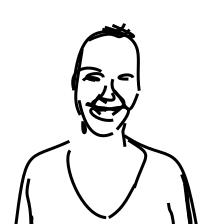

In [33]:
def compute_scale(x1, y1, x2, y2, orig_w=128, orig_h=128):
    new_w, new_h = (x2 - x1, y2 - y1)  # the size of the bounding box
    width_ratio = new_w / orig_w
    height_ratio = new_h / orig_h
    return width_ratio, height_ratio

def composite(patches, width, height):
    composite = SVG([], (width, height), width=width, height=height)
    for _, patch in patches.items():
        svg = SVG.load_svg(os.path.join(sample_dir, "complex", patch["file"]))
        
        (x1, y1, x2, y2) = patch["bounding_box"]
        (_x1, _y1), (_x2, _y2) = svg.bbox()
        
        # compute width and height for the box rather than the full image
        _w, _h = _x2 - _x1, _y2 - _y1
        width_ratio, height_ratio = compute_scale(x1, y1, x2, y2, _w, _h)

        target_center = Point((x1 + x2) // 2, (y1 + y2) // 2)
        
        svg.scale((width_ratio, height_ratio))
        svg.translate(-svg.viewbox.center)
        svg.translate(target_center)
        composite = composite + svg 
    return composite

result = composite(patches, width, height)

white_bg = Image.new("RGBA", (width, height), "WHITE")
white_bg.paste(
    result.draw(return_png=True, do_display=False), 
    (0, 0), 
    result.draw(return_png=True, do_display=False)
    ) 
white_bg.convert("RGB").show()